# LMDZ CM6 ICO : SNOW DURATION 
#### https://forge.ipsl.jussieu.fr/igcmg/wiki/IPSLCM6/IPSL-CM6A-ATM-ICO

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from pathlib import Path
import calendar as cal

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

In [2]:
# For parallelisation
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43177 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


In [3]:
# Define zone : ALPS
latlim=(43.5,48.5) 
lonlim=(5,16.5)

# Make a extended version for regridding properly on the edges
latlim_ext = (latlim[0]-5, latlim[-1]+5)
lonlim_ext = (lonlim[0]-5, lonlim[-1]+5)

list_var = ['tas', 'pr', 'snc']
list_res = ['lr', 'mr', 'hr', 'vhr']

# INPUTS

## 1. Load Observations

#### 1.1. ECAD Temperature

In [4]:
# OPEN ECAD temperature dataset for the first time : MERGE ET Monthly-Average
# file_name_ecad = 'tg_ens_mean_0.1deg_reg_v27.0e.nc'
# folder_name_ecad = '/data/xfain/ECAD'

# ds_temp= xr.open_mfdataset(folder_name_ecad + '/' + file_name_ecad, parallel=True).sel(latitude=slice(latlim_ext[0],latlim_ext[1]),longitude=slice(lonlim_ext[0],lonlim_ext[1])).tg.load()
# ds_temp = ds_temp.rename({'latitude': 'lat','longitude': 'lon'})
# ds_temp_mon = ds_temp.resample(time='M').mean()

# SAVE Monthly Processed ECAD Temperature dataset for Alpine area only
#ds_temp_mon.to_netcdf('/data/xfain/ECAD/tg_ens_mean_0.1deg_reg_v27.0e_monthly.nc')

In [5]:
# OPEN ECAD temperature dataset PreProcessed at MONTHLY Resolution

file_name_ecad_monthly = 'tg_ens_mean_0.1deg_reg_v27.0e_monthly.nc'
folder_name_ecad = '/data/xfain/ECAD/'

ds_temp_mon= xr.open_mfdataset(folder_name_ecad + '/' + file_name_ecad_monthly).tg.load()

#### 1.2. SNOW-CCI datasets

In [6]:
# OPEN Snow-CCI datasets
folder_name_ESA_CCI_SNOW = '/data/xfain/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/'#monthly_0.25deg/'
ds_025 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_0.25deg'+'/*.nc', combine='by_coords', parallel=True)
ds_050 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_0.5deg'+'/*.nc', combine='by_coords', parallel=True)
ds_100 = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly_1deg'+'/*.nc', combine='by_coords', parallel=True)
ds_raw = xr.open_mfdataset(folder_name_ESA_CCI_SNOW + 'monthly'+'/*.nc', combine='by_coords', parallel=True)
# Available résolution GapFilled (directory): monthly_0.1deg  monthly_0.25deg  monthly_0.5deg  monthly_1deg
# AW DATA before GapFilling: /data/xfain/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly$

In [7]:
# CORRECTIONS sur SNOW-CCI data (M. Lalalande)
# Les données d'octobre 1994 sont à ignorer
# Celles de Nov 94 => Janv 95 inéxistantes, et il faut créer des index de NaN

snow_cci_interp_025 = ds_025['scfg_interp_0.25deg_icefilled']
snow_cci_interp_050 = ds_050['scfg_interp_0.5deg_icefilled']
snow_cci_interp_100 = ds_100['scfg_interp_1deg_icefilled']
snow_cci_raw = ds_raw['scfg_interp']

# reindex to add dates from nov 1994 to jan 1995
snow_cci_interp_025 = snow_cci_interp_025.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
snow_cci_interp_025.load()
snow_cci_interp_050 = snow_cci_interp_050.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
snow_cci_interp_050.load()
snow_cci_interp_100 = snow_cci_interp_100.reindex(time=pd.date_range('1982-01-31T00:00:00.000000000', '2014-12-31T00:00:00.000000000', freq='M'))  # to adapt to your period (import pandas as pd before)
snow_cci_interp_100.load()

 
# set to nan all values from '1994-10' because of too much missing values leading to wrong spatial average
snow_cci_interp_025.loc['1994-10'] = snow_cci_interp_025.loc['1994-11'].values #snow_cci_interp.loc['1994-11'].values are nan because no values
snow_cci_interp_050.loc['1994-10'] = snow_cci_interp_050.loc['1994-11'].values
snow_cci_interp_100.loc['1994-10'] = snow_cci_interp_100.loc['1994-11'].values

In [8]:
snc_025= snow_cci_interp_025.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
snc_050= snow_cci_interp_050.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
snc_100= snow_cci_interp_100.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
snc_raw = snow_cci_raw.sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).load()
snc_list =[snc_025,snc_050,snc_100]

## 2. Load Model outputs

In [9]:
# Directory where LMDZ extracted output data are saved
ldmz_output_path='/data/xfain/LMDZ_CM6_ICO'

In [10]:
#List LR files # Monthly resolution
file_name_lr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_lr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_lr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_LR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-LR-01.sponge.run.01/CMIP6/ATM'
folder_name_LR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-LR-01.sponge.run.01/CMIP6/SRF'

In [11]:
#List MR files # Monthly resolution
file_name_mr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_mr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_mr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_MR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-MR-01.sponge.run.01/CMIP6/ATM'
folder_name_MR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-MR-01.sponge.run.01/CMIP6/SRF'

In [12]:
#List HR files # Monthly resolution
file_name_hr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_hr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_hr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_HR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/ATM'
folder_name_HR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-HR.sponge.run.01/CMIP6/SRF'

In [13]:
#List VHR files # Monthly resolution
file_name_vhr_tas = 'tas_Amon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_vhr_pr = 'pr_Amon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
file_name_vhr_snc = 'snc_LImon_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr_*.nc'
folder_name_VHR_ATM = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/ATM'
folder_name_VHR_SRF = '/thredds/tgcc/work/p86caub/ICOLMDZOR/PROD/highresSST-present/CM6-ICO-VHR.sponge.run.01/CMIP6/SRF'

In [14]:
#Open and combine all LR dataset
path_tas = Path(ldmz_output_path+'/ds_lr_tas.nc')
path_pr = Path(ldmz_output_path+'/ds_lr_pr.nc')
path_snc = Path(ldmz_output_path+'/ds_lr_snc.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_lr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_lr_tas.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the LR TAS data')
    ds_lr_tas= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_lr_tas.to_netcdf(ldmz_output_path+'/ds_lr_tas.nc')
   
if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_lr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_lr_pr.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the LR PR data')
    ds_lr_pr= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_lr_pr.to_netcdf(ldmz_output_path+'/ds_lr_pr.nc')

if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_lr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_lr_snc.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the LR SNC data')
    ds_lr_snc= xr.open_mfdataset(folder_name_LR_SRF + '/' + file_name_lr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_lr_snc.to_netcdf(ldmz_output_path+'/ds_lr_snc.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_lr_tas.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_lr_pr.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_lr_snc.nc already exists


In [15]:
#Open and combine all MR dataset
path_tas = Path(ldmz_output_path+'/ds_mr_tas.nc')
path_pr = Path(ldmz_output_path+'/ds_mr_pr.nc')
path_snc = Path(ldmz_output_path+'/ds_mr_snc.nc')

if path_tas.is_file():
    print(f'The MR TAS file {path_tas} already exists')
    ds_mr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_mr_tas.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the MR TAS data')
    ds_mr_tas= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_mr_tas.to_netcdf(ldmz_output_path+'/ds_mr_tas.nc')
    
if path_pr.is_file():
    print(f'The  file {path_pr} already exists')
    ds_mr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_mr_pr.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the MR PR data')
    ds_mr_pr= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_mr_pr.to_netcdf(ldmz_output_path+'/ds_mr_pr.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_mr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_mr_snc.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the MR SNC data')
    ds_mr_snc= xr.open_mfdataset(folder_name_MR_SRF + '/' + file_name_mr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_mr_snc.to_netcdf(ldmz_output_path+'/ds_mr_snc.nc')

The MR TAS file /data/xfain/LMDZ_CM6_ICO/ds_mr_tas.nc already exists
The  file /data/xfain/LMDZ_CM6_ICO/ds_mr_pr.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_mr_snc.nc already exists


In [16]:
#Open and combine all HR dataset
path_tas = Path(ldmz_output_path+'/ds_hr_tas.nc')
path_pr = Path(ldmz_output_path+'/ds_hr_pr.nc')
path_snc = Path(ldmz_output_path+'/ds_hr_snc.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_hr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_hr_tas.nc', parallel=True).tas.load()
else:
    print(f'The HR file {path_tas} does not exist')
    print(f'Extracting the HR TAS data')
    ds_hr_tas= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_hr_tas.to_netcdf(ldmz_output_path+'/ds_hr_tas.nc')
    
if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_hr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_hr_pr.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the HR PR data')
    ds_hr_pr= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_hr_pr.to_netcdf(ldmz_output_path+'/ds_hr_pr.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_hr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_hr_snc.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the HR SNC data')
    ds_hr_snc= xr.open_mfdataset(folder_name_HR_SRF + '/' + file_name_hr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_hr_snc.to_netcdf(ldmz_output_path+'/ds_hr_snc.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_hr_tas.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_hr_pr.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_hr_snc.nc already exists


In [17]:
#Open and combine all VHR dataset
path_tas = Path(ldmz_output_path+'/ds_vhr_tas.nc')
path_pr = Path(ldmz_output_path+'/ds_vhr_pr.nc')
path_snc = Path(ldmz_output_path+'/ds_vhr_snc.nc')

if path_tas.is_file():
    print(f'The file {path_tas} already exists')
    ds_vhr_tas = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_tas.nc', parallel=True).tas.load()
else:
    print(f'The file {path_tas} does not exist')
    print(f'Extracting the VHR TAS data')
    ds_vhr_tas= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_tas, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).tas.load()
    ds_vhr_tas.to_netcdf(ldmz_output_path+'/ds_vhr_tas.nc')
    
if path_pr.is_file():
    print(f'The file {path_pr} already exists')
    ds_vhr_pr = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_pr.nc', parallel=True).pr.load()
else:
    print(f'The file {path_pr} does not exist')
    print(f'Extracting the VHR PR data')
    ds_vhr_pr= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_pr, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).pr.load()
    ds_vhr_pr.to_netcdf(ldmz_output_path+'/ds_vhr_pr.nc')
    
if path_snc.is_file():
    print(f'The file {path_snc} already exists')
    ds_vhr_snc = xr.open_mfdataset(ldmz_output_path+'/ds_vhr_snc.nc', parallel=True).snc.load()
else:
    print(f'The file {path_snc} does not exist')
    print(f'Extracting the VHR SNC data')
    ds_vhr_snc= xr.open_mfdataset(folder_name_VHR_SRF + '/' + file_name_vhr_snc, concat_dim ='time', combine='by_coords', parallel=True).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).snc.load()
    ds_vhr_snc.to_netcdf(ldmz_output_path+'/ds_vhr_snc.nc')

The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_tas.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_pr.nc already exists
The file /data/xfain/LMDZ_CM6_ICO/ds_vhr_snc.nc already exists


In [18]:
ds_lr = xr.concat((ds_lr_tas-273.15, ds_lr_pr*86400, ds_lr_snc), pd.Index(list_var, name='var'))
ds_mr = xr.concat((ds_mr_tas-273.15, ds_mr_pr*86400, ds_mr_snc), pd.Index(list_var, name='var'))
ds_hr = xr.concat((ds_hr_tas-273.15, ds_hr_pr*86400, ds_hr_snc), pd.Index(list_var, name='var'))
ds_vhr = xr.concat((ds_vhr_tas-273.15, ds_vhr_pr*86400, ds_vhr_snc), pd.Index(list_var, name='var'))
    
ds_list = [ds_lr, ds_mr, ds_hr, ds_vhr]

## 3. Load Dynamico Orography

In [19]:
#From https://github.com/mickaellalande/MC-Toolkit/blob/master/conda_environment_xarray_xesmf_proplot/xarray/quick-overview.ipynb
def spatial_average(da):
    coslat = np.cos(np.deg2rad(da.lat)).where(~da.isnull())
    weights = coslat / coslat.sum(dim=('lat', 'lon'))
    return (da * weights).sum(dim=('lat','lon'))

In [20]:
file_name_lr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-LR_highresSST-present_r1i1p1f1_gr.nc'
file_name_mr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-MR_highresSST-present_r1i1p1f1_gr.nc'
file_name_hr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-HR_highresSST-present_r1i1p1f1_gr.nc'
file_name_vhr_orog ='orog_fx_IPSL-CM6A-ATM-ICO-VHR_highresSST-present_r1i1p1f1_gr.nc'

In [21]:
ds_lr_orog= xr.open_mfdataset(folder_name_LR_ATM + '/' + file_name_lr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_mr_orog= xr.open_mfdataset(folder_name_MR_ATM + '/' + file_name_mr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_hr_orog= xr.open_mfdataset(folder_name_HR_ATM + '/' + file_name_hr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()
ds_vhr_orog= xr.open_mfdataset(folder_name_VHR_ATM + '/' + file_name_vhr_orog).sel(lat=slice(latlim_ext[0],latlim_ext[1]),lon=slice(lonlim_ext[0],lonlim_ext[1])).orog.load()

## 4. Compute snow duration calculations

In [22]:
# Parameters to compute snow cover duration
scf_threshold=0.1 #A cell is considered "snow-covered" if at least 10% of its surface is snow-covered.
min_available_values=15 #ne s'applique pas à LMDZ
min_available_values2=20 # Second value for testing/comparison

# Defining the time for the monthly data
first_year=1950# ds_lr_snc[0].time
last_year=2013 #ds_lr_snc[-1].time
#period = slice(str(first_year)+'-01-01',str(last_year)+'-12-31')

months_per_year=12
time_nbdays = pd.date_range(start=str(first_year)+'-01',end=str(last_year+1)+'-12',freq='M')
reference_time = pd.Timestamp(str(first_year)+'-01')

In [23]:
#nbdays = nombre de jours enneigés sur un mois

# Initialise the array 12 month per year nbdays array
path_nbdays = Path(ldmz_output_path+'/LMDZ_alpine_snow_nbdays.nc')
if path_nbdays.is_file():
    print(f'The file {path_nbdays} already exists')
else:
    print(f'The file {path_nbdays} does not exist')
    ds_nbdays = xr.Dataset({
        'nbdays': xr.DataArray(
            data=np.full((ds_lr_snc.lat.shape[0],ds_lr_snc.lon.shape[0],time_nbdays.shape[0]), np.nan),
            dims=["lat", "lon", "time"],
            coords=dict(
                lat=(["lat"], ds_lr_snc.lat),
                lon=(["lon"], ds_lr_snc.lon),
                time=time_nbdays,
                reference_time=reference_time,
            ),
            name='nbdays',
            attrs=dict(
                description="snow cover duration",
                units="days month-1",
            ),
            ),
        },
        attrs = {'documentation': 'Snow cover duration from LDMZ-CM6-ICO snow cover fraction outputs.'}
    )  

The file /data/xfain/LMDZ_CM6_ICO/LMDZ_alpine_snow_nbdays.nc already exists


In [163]:
year=1950
for i in range(ds_lr_snc.time.size-1):
    for imonth in range(1,13,1):
        numday_month=cal.monthrange(year, imonth)[1]
        temp =(str(year)+', month='+str(imonth)+', number of days='+str(numday_month))
        #print(temp)
    year=year+1
        #print('year='+str(year)+', month='+str(imonth)+', number of days='+str(numday_month))

In [178]:
# nbdays calculation (From Martin)
# 1. for each year and month, we select the gridcell with snc > threshold=0.1 (for which the gridcell is considered snow covered.
# T2. sum the snow covered days for each month 

#on fait pas  les 3 étapes ci dessous:
# where there is more than min_available_values (and min_available_values2 for comparison).
# Finally, the total number of snow covered days is extrapolated at the monthly timescale,
# extending the ratio (snow-covered days)/(number of days with available data) to the whole number of days in the month.


path_nbdays = Path(ldmz_output_path+'/LMDZ_alpine_snow_nbdays.nc')
#if path_nbdays.is_file():
#    print(f'The file {path_nbdays} already exists')
#    ds_nbdays = xr.open_mfdataset(ldmz_output_path+'/LMDZ_alpine_snow_nbdays.nc', parallel=True)
#else:
for iyear, year in enumerate(range(first_year, last_year+1, 1)):
    print(year)
    for imonth in range(1,months_per_year+1,1):
        print(imonth)
        numday_month=cal.monthrange(year, imonth)[1]
#        print('year='+str(year)+', month='+str(imonth)+', number of days='+str(numday_month))
        print('computing nbdays')
        ds_tmp=ds_lr_snc.sel(time=str(year)+'-'+str(imonth))
#        print(ds_tmp)
        binary=xr.where(ds_tmp > scf_threshold, 1., 0.)
        print(binary)
        xnbdays=binary.sum(dim='time',skipna=True)
        print(xnbdays)
#        print(binary)
#        binary=xr.where(xr.ufuncs.isnan(ds_tmp), np.nan, binary_tmp)
#        xnbdays=binary.sum(dim='time')#,skipna=True)#,min_count=min_available_values)
#        print(xnbdays)
#            xnbdays2=binary.sum(dim='time',skipna=True,min_count=min_available_values2)
#            cov=ds_lr_snc.coverage_interp.sel(time=str(year)+'-'+str(imonth)+'-01')
#            xnbdays_filled=(xnbdays/cov)*numday_month
#            ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays_filled[:,:,0]=xnbdays_filled
        ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays[:,:,0]=xnbdays
#            ds_nbdays.sel(time=str(year)+'-'+str(imonth)).nbdays2[:,:,0]=xnbdays2
ds_nbdays.to_netcdf(ldmz_output_path+'/LMDZ_alpine_snow_nbdays.nc')

SyntaxError: cannot assign to function call (<ipython-input-178-6dcc37290717>, line 37)

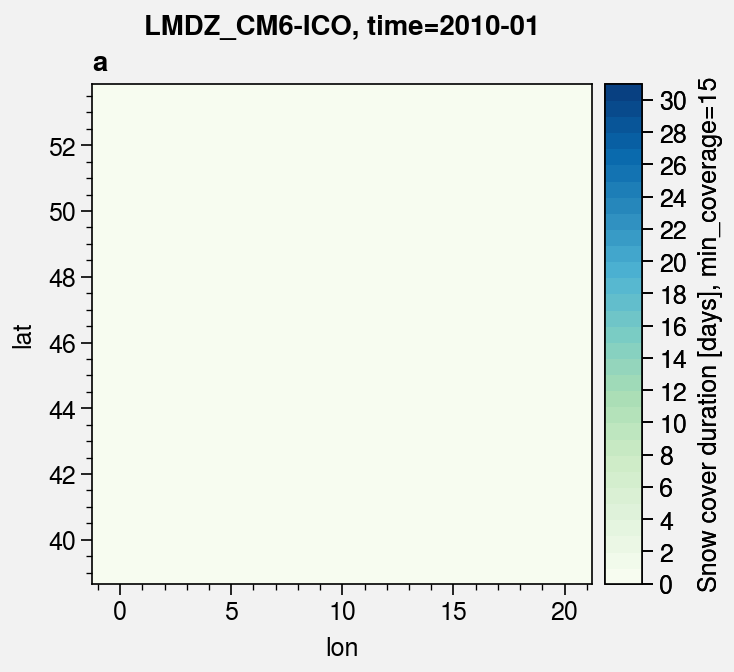

In [107]:
# Check the result for one specific date
time_check='2010-01'
levels_nbdays=plot.arange(0,31,1)
#levels_elev=plot.arange(0,1000,1000)
cmap='GnBu'


fig,axs = plot.subplots(nrows=1, ncols=1)
axs[0,0].pcolormesh(ds_nbdays.nbdays.sel(time=time_check)[:,:,0], levels=levels_nbdays, cmap=cmap, colorbar='r', 
                    colorbar_kw={'label': 'Snow cover duration [days])})
#axs[0,0].contour(dsi_topo.elevation, levels=levels_elev, color='gray8',labels=True,lw=1.2)

axs.format(
    suptitle='LMDZ-CM6-ICO, time='+time_check,
    abc=True
)

